In [1]:
!pip install --upgrade  torchvision facenet-pytorch

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 55.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 69.0 MB/s eta 0:00:00:00:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 17.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 20.

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import pandas as pd
import numpy as np
import os
import time

# To handle truncated images gracefully
ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- Important Prerequisite ---
# This library is used for high-quality, on-the-fly face detection and alignment.
from facenet_pytorch import MTCNN

In [3]:
#import kagglehub
import shutil
# Download latest version
#path = kagglehub.dataset_download("pdombrza/cacd-filtered-dataset")

#shutil.copytree("/root/.cache/kagglehub/datasets/pdombrza/cacd-filtered-dataset", "/content/cacd-filtered-dataset")

In [4]:
import os
import shutil
import pandas as pd

# Paths
csv_path = "/kaggle/input/cacd-filtered-dataset/CACD_features_sex.csv"
images_root = "/kaggle/input/cacd-filtered-dataset/cacd_split/cacd_split"
output_root = "/kaggle/working/cacd_filtered_top500"
output_csv_path = "/kaggle/working/CACD_features_top500.csv"

# Create output directory
os.makedirs(output_root, exist_ok=True)

# Load CSV
df = pd.read_csv(csv_path)

# Extract person folder name from image filename (e.g., "AaronAshmore" from "25_Aaron_Ashmore_0005.jpg")
df["person"] = df["name"].apply(lambda x: "_".join(x.split("_")[1:-1]).replace("_", ""))

# Step 1: Compute age variation per person
age_variation = df.groupby("person")["age"].agg(lambda x: x.max() - x.min())

# Step 2: Select top 1000 persons with largest age variation
top_persons = age_variation.sort_values(ascending=False).head(500).index

# Step 3: Filter dataframe
filtered_df = df[df["person"].isin(top_persons)].copy()

# Step 4: Copy images into new folder structure
for _, row in filtered_df.iterrows():
    person = row["person"]
    img_name = row["name"]  # e.g., "25_Aaron_Ashmore_0005.jpg"
    
    src = os.path.join(images_root, person, img_name)
    dst_dir = os.path.join(output_root, person)
    dst = os.path.join(dst_dir, img_name)
    
    os.makedirs(dst_dir, exist_ok=True)
    
    if os.path.exists(src):
        shutil.copy(src, dst)

# Step 5: Save new CSV
filtered_df.to_csv(output_csv_path, index=False)

print(f"✅ Done! Filtered dataset saved at: {output_root}")
print(f"CSV saved at: {output_csv_path}")


✅ Done! Filtered dataset saved at: /kaggle/working/cacd_filtered_top500
CSV saved at: /kaggle/working/CACD_features_top500.csv


In [5]:
#shutil.move("/kaggle/working/cacd_filtered_top1000/CACD_features_top1000.csv", "/kaggle/working/CACD_features_top1000.csv")

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# --- Configuration ---
CSV_PATH = '/kaggle/working/CACD_features_top500.csv'
IMAGE_DIR = '/kaggle/working/cacd_filtered_top500'

# --- Main Script ---

# 1. LOAD AND PREPARE DATA
print("--- 1. Loading and Preparing Data ---")
try:
    metadata_df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"ERROR: Metadata CSV not found at {CSV_PATH}")
    exit()

print(f"Loaded metadata with {len(metadata_df)} rows.")
print("\nMetadata Head (contains filename in 'name' column):")
print(metadata_df.head())

# Scan the image directory to get all existing image paths and their parent folder (identity name)
print("\nScanning image directory...")
all_image_paths = []
all_identity_names = []
# Using tqdm for a progress bar, which is helpful for large directories
for identity_name in tqdm(os.listdir(IMAGE_DIR)):
    identity_path = os.path.join(IMAGE_DIR, identity_name)
    if os.path.isdir(identity_path):
        for img_file in os.listdir(identity_path):
            if img_file.lower().endswith('.jpg'):
                all_image_paths.append(os.path.join(identity_path, img_file))
                all_identity_names.append(identity_name)

# Create a DataFrame from the actual files on disk
files_df = pd.DataFrame({
    'image_path': all_image_paths,
    'identity_name': all_identity_names
})
print(f"Found {len(files_df)} images on disk.")

# --- THE FIX IS HERE ---
# Create a 'filename' column by extracting the base name from the full path.
# This will be our merge key.
files_df['filename'] = files_df['image_path'].apply(os.path.basename)

print("\nfiles_df Head (with the new 'filename' key):")
print(files_df.head())

# Now, merge using the correct keys: 'filename' from our disk scan and 'name' from the CSV.
manifest_df = pd.merge(files_df, metadata_df, left_on='filename', right_on='name', how='inner')

--- 1. Loading and Preparing Data ---
Loaded metadata with 38877 rows.

Metadata Head (contains filename in 'name' column):
   Unnamed: 0  age  identity  year  rank  lfw  birth  \
0         319   53         5  2004     5    0   1951   
1         320   53         5  2004     5    0   1951   
2         321   53         5  2004     5    0   1951   
3         322   53         5  2004     5    0   1951   
4         323   53         5  2004     5    0   1951   

                          name gender          person  
0  53_Anjelica_Huston_0001.jpg      F  AnjelicaHuston  
1  53_Anjelica_Huston_0002.jpg      F  AnjelicaHuston  
2  53_Anjelica_Huston_0003.jpg      F  AnjelicaHuston  
3  53_Anjelica_Huston_0004.jpg      F  AnjelicaHuston  
4  53_Anjelica_Huston_0007.jpg      F  AnjelicaHuston  

Scanning image directory...


  0%|          | 0/500 [00:00<?, ?it/s]

Found 38877 images on disk.

files_df Head (with the new 'filename' key):
                                          image_path   identity_name  \
0  /kaggle/working/cacd_filtered_top500/CristinMi...  CristinMilioti   
1  /kaggle/working/cacd_filtered_top500/CristinMi...  CristinMilioti   
2  /kaggle/working/cacd_filtered_top500/CristinMi...  CristinMilioti   
3  /kaggle/working/cacd_filtered_top500/CristinMi...  CristinMilioti   
4  /kaggle/working/cacd_filtered_top500/CristinMi...  CristinMilioti   

                      filename  
0  27_Cristin_Milioti_0002.jpg  
1  25_Cristin_Milioti_0012.jpg  
2  26_Cristin_Milioti_0003.jpg  
3  25_Cristin_Milioti_0016.jpg  
4  23_Cristin_Milioti_0016.jpg  


In [7]:
print(f"\nSuccessfully merged file paths with metadata. Resulting manifest has {len(manifest_df)} entries.")
if len(manifest_df) == 0:
    print("\n\nCRITICAL ERROR: The merge resulted in an empty DataFrame. Please check:")
    


Successfully merged file paths with metadata. Resulting manifest has 38877 entries.


In [8]:
manifest_df

,image_path,identity_name,filename,Unnamed: 0,age,identity,year,rank,lfw,birth,name,gender,person
0,/kaggle/working/cacd_filtered_top500/CristinMi...,CristinMilioti,27_Cristin_Milioti_0002.jpg,139593,27,1709,2012,9,0,1985,27_Cristin_Milioti_0002.jpg,F,CristinMilioti
1,/kaggle/working/cacd_filtered_top500/CristinMi...,CristinMilioti,25_Cristin_Milioti_0012.jpg,139579,25,1709,2010,9,0,1985,25_Cristin_Milioti_0012.jpg,F,CristinMilioti
2,/kaggle/working/cacd_filtered_top500/CristinMi...,CristinMilioti,26_Cristin_Milioti_0003.jpg,139585,26,1709,2011,9,0,1985,26_Cristin_Milioti_0003.jpg,F,CristinMilioti
3,/kaggle/working/cacd_filtered_top500/CristinMi...,CristinMilioti,25_Cristin_Milioti_0016.jpg,139582,25,1709,2010,9,0,1985,25_Cristin_Milioti_0016.jpg,F,CristinMilioti
4,/kaggle/working/cacd_filtered_top500/CristinMi...,CristinMilioti,23_Cristin_Milioti_0016.jpg,139571,23,1709,2008,9,0,1985,23_Cristin_Milioti_0016.jpg,F,CristinMilioti
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38872,/kaggle/working/cacd_filtered_top500/BreeTurne...,BreeTurner,30_Bree_Turner_0014.jpg,108354,30,1344,2007,44,0,1977,30_Bree_Turner_0014.jpg,F,BreeTurner
38873,/kaggle/working/cacd_filtered_top500/BreeTurne...,BreeTurner,35_Bree_Turner_0013.jpg,108393,35,1344,2012,44,0,1977,35_Bree_Turner_0013.jpg,F,BreeTurner
38874,/kaggle/working/cacd_filtered_top500/BreeTurne...,BreeTurner,33_Bree_Turner_0011.jpg,108368,33,1344,2010,44,0,1977,33_Bree_Turner_0011.jpg,F,BreeTurner
38875,/kaggle/working/cacd_filtered_top500/BreeTurne...,BreeTurner,28_Bree_Turner_0009.jpg,108344,28,1344,2005,44,0,1977,28_Bree_Turner_0009.jpg,F,BreeTurner


In [9]:
# 2. CLEAN AND ENGINEER FEATURES
print("\n--- 2. Cleaning and Feature Engineering ---")

manifest_df['age'] = manifest_df['age'].astype(int)
manifest_df['identity_id'], unique_names = pd.factorize(manifest_df['identity_name'])

bins = [0, 10, 20, 30, 40, 50, 60, 120]
labels = ['10-', '11-20', '21-30', '31-40', '41-50', '51-60', '61+']
manifest_df['age_group'] = pd.cut(manifest_df['age'], bins=bins, labels=labels, right=True)

final_cols = ['image_path', 'identity_id', 'identity_name', 'age', 'age_group', 'gender']
manifest_df = manifest_df[final_cols].copy()

print("\nFinal Manifest Head:")
print(manifest_df.head())
print(f"\nTotal unique identities in the final manifest: {manifest_df['identity_id'].nunique()}")



--- 2. Cleaning and Feature Engineering ---

Final Manifest Head:
                                          image_path  identity_id  \
0  /kaggle/working/cacd_filtered_top500/CristinMi...            0   
1  /kaggle/working/cacd_filtered_top500/CristinMi...            0   
2  /kaggle/working/cacd_filtered_top500/CristinMi...            0   
3  /kaggle/working/cacd_filtered_top500/CristinMi...            0   
4  /kaggle/working/cacd_filtered_top500/CristinMi...            0   

    identity_name  age age_group gender  
0  CristinMilioti   27     21-30      F  
1  CristinMilioti   25     21-30      F  
2  CristinMilioti   26     21-30      F  
3  CristinMilioti   25     21-30      F  
4  CristinMilioti   23     21-30      F  

Total unique identities in the final manifest: 500



--- 3. Generating EDA Report ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


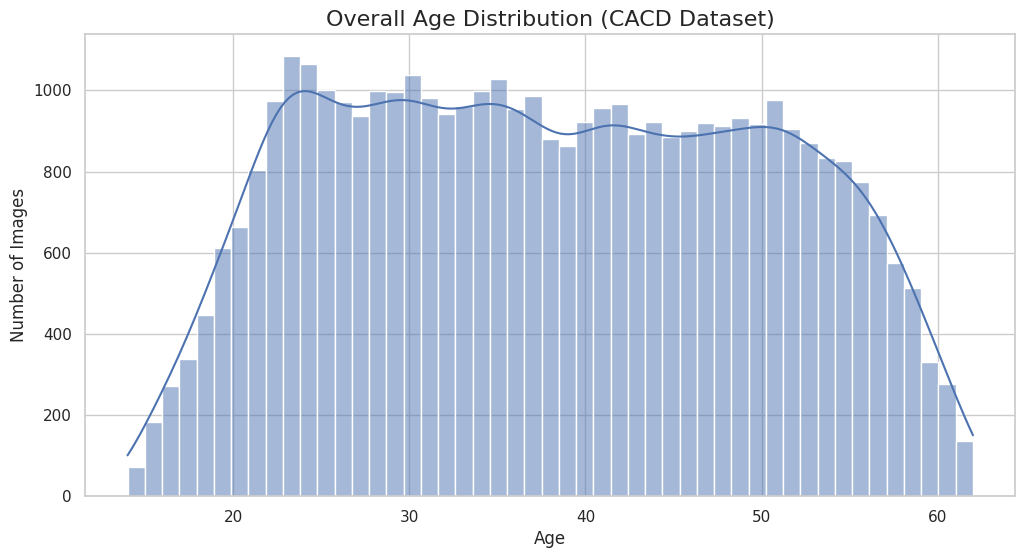

In [10]:

# 3. EXPLORATORY DATA ANALYSIS (EDA)
print("\n--- 3. Generating EDA Report ---")
# (The EDA code from here on remains the same and will now work correctly)
sns.set_theme(style="whitegrid")

# EDA 1: Overall Age Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=manifest_df, x='age', bins=manifest_df['age'].nunique(), kde=True)
plt.title('Overall Age Distribution (CACD Dataset)', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


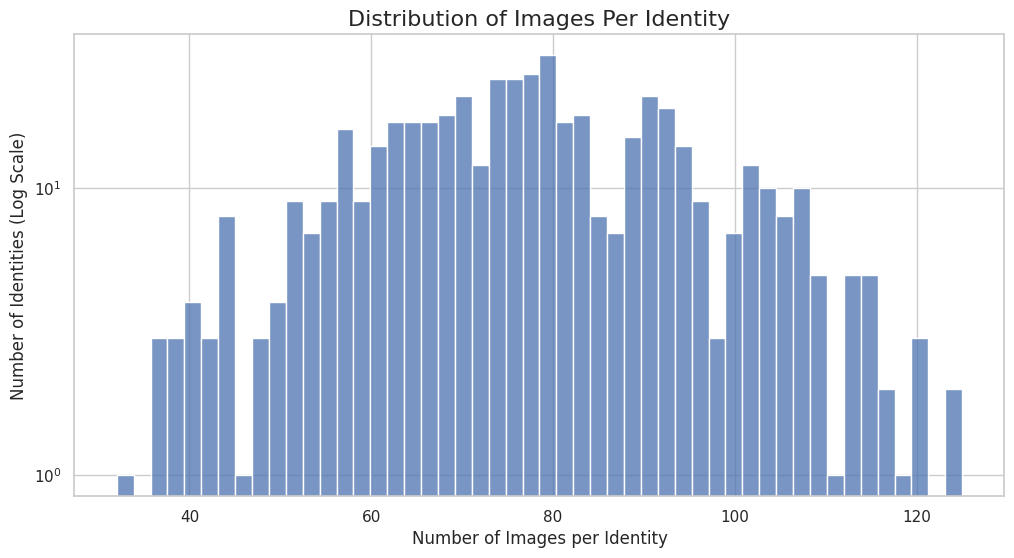

In [11]:
# EDA 2: Images Per Identity
images_per_id = manifest_df['identity_id'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(images_per_id, log_scale=(False, True), bins=50)
plt.title('Distribution of Images Per Identity', fontsize=16)
plt.xlabel('Number of Images per Identity', fontsize=12)
plt.ylabel('Number of Identities (Log Scale)', fontsize=12)
plt.show()

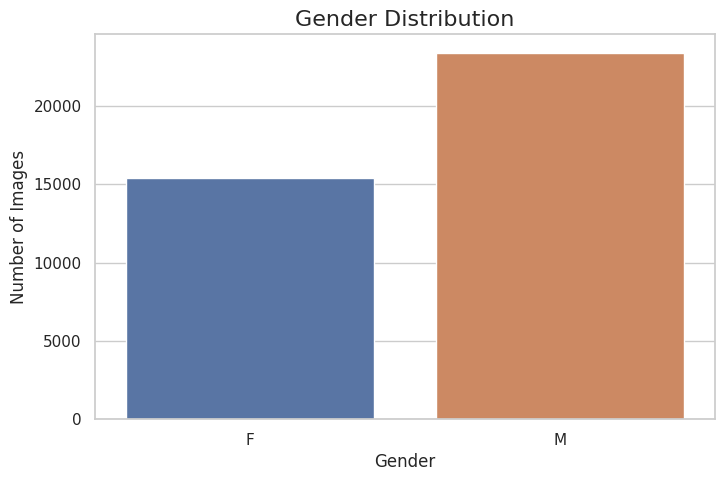

In [12]:
# EDA 4: Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=manifest_df, x='gender')
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

In [13]:
# 4. CREATE IDENTITY-DISJOINT SPLITS
print("\n--- 4. Creating Train/Val/Test Splits (Identity-Disjoint) ---")
unique_identities = manifest_df['identity_id'].unique()
train_ids, test_val_ids = train_test_split(unique_identities, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, random_state=42)

print(f"Total identities: {len(unique_identities)}")
print(f"Train identities: {len(train_ids)}")
print(f"Validation identities: {len(val_ids)}")
print(f"Test identities: {len(test_ids)}")

assert len(set(train_ids) & set(val_ids)) == 0
assert len(set(train_ids) & set(test_ids)) == 0
assert len(set(val_ids) & set(test_ids)) == 0
print("\nVerified: No identity overlap between splits.")

train_manifest = manifest_df[manifest_df['identity_id'].isin(train_ids)]
val_manifest = manifest_df[manifest_df['identity_id'].isin(val_ids)]
test_manifest = manifest_df[manifest_df['identity_id'].isin(test_ids)]

print(f"\nTrain manifest: {len(train_manifest)} images from {len(train_ids)} identities")
print(f"Validation manifest: {len(val_manifest)} images from {len(val_ids)} identities")
print(f"Test manifest: {len(test_manifest)} images from {len(test_ids)} identities")


--- 4. Creating Train/Val/Test Splits (Identity-Disjoint) ---
Total identities: 500
Train identities: 300
Validation identities: 100
Test identities: 100

Verified: No identity overlap between splits.

Train manifest: 23539 images from 300 identities
Validation manifest: 7810 images from 100 identities
Test manifest: 7528 images from 100 identities


In [14]:
# 5. SAVE DELIVERABLES
print("\n--- 5. Saving Deliverables ---")
os.makedirs('manifests', exist_ok=True)
train_manifest.to_csv('manifests/train_manifest.csv', index=False)
val_manifest.to_csv('manifests/val_manifest.csv', index=False)
test_manifest.to_csv('manifests/test_manifest.csv', index=False)
print("Saved train, val, and test manifests to the 'manifests/' directory.")


--- 5. Saving Deliverables ---
Saved train, val, and test manifests to the 'manifests/' directory.


In [15]:
train_df = pd.read_csv('/kaggle/working/manifests/train_manifest.csv')

In [16]:
train_df

,image_path,identity_id,identity_name,age,age_group,gender
0,/kaggle/working/cacd_filtered_top500/BenStille...,1,BenStiller,46,41-50,M
1,/kaggle/working/cacd_filtered_top500/BenStille...,1,BenStiller,40,31-40,M
2,/kaggle/working/cacd_filtered_top500/BenStille...,1,BenStiller,45,41-50,M
3,/kaggle/working/cacd_filtered_top500/BenStille...,1,BenStiller,42,41-50,M
4,/kaggle/working/cacd_filtered_top500/BenStille...,1,BenStiller,48,41-50,M
...,...,...,...,...,...,...
23534,/kaggle/working/cacd_filtered_top500/BreeTurne...,499,BreeTurner,30,21-30,F
23535,/kaggle/working/cacd_filtered_top500/BreeTurne...,499,BreeTurner,35,31-40,F
23536,/kaggle/working/cacd_filtered_top500/BreeTurne...,499,BreeTurner,33,31-40,F
23537,/kaggle/working/cacd_filtered_top500/BreeTurne...,499,BreeTurner,28,21-30,F


--- 1. Loading the original training manifest ---
Loaded original training manifest with 23539 images.

--- 2. Analyzing class distribution (BEFORE capping) ---

Statistics for images per identity (BEFORE):
count    300.000000
mean      78.463333
std       17.958573
min       37.000000
25%       65.000000
50%       77.000000
75%       91.000000
max      125.000000
Name: count, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


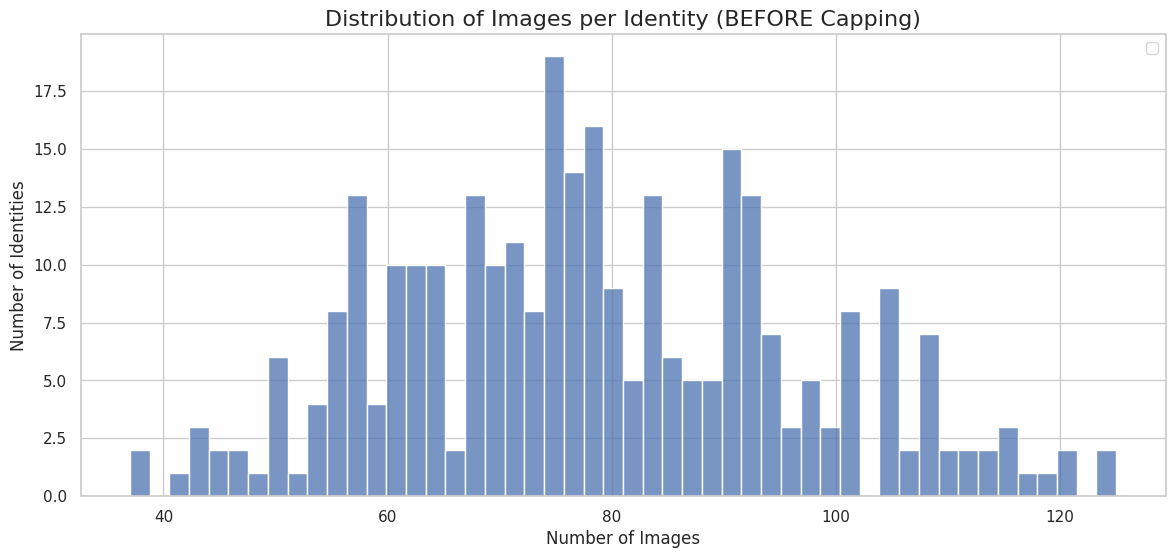

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# The manifest created in the previous step
TRAIN_MANIFEST_PATH = '/kaggle/working/manifests/train_manifest.csv'


# --- Main Script ---

# 1. LOAD THE TRAINING MANIFEST
print("--- 1. Loading the original training manifest ---")
try:
    train_df = pd.read_csv(TRAIN_MANIFEST_PATH)
except FileNotFoundError:
    print(f"ERROR: Manifest not found at {TRAIN_MANIFEST_PATH}")
    print("Please run the previous Task A script first.")
    exit()

print(f"Loaded original training manifest with {len(train_df)} images.")

# 2. ANALYZE THE IMBALANCE (BEFORE)
print("\n--- 2. Analyzing class distribution (BEFORE capping) ---")
image_counts_before = train_df['identity_id'].value_counts()

print("\nStatistics for images per identity (BEFORE):")
print(image_counts_before.describe())

# Plot the distribution before capping
plt.figure(figsize=(14, 6))
sns.histplot(image_counts_before, bins=50)
plt.title('Distribution of Images per Identity (BEFORE Capping)', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Number of Identities', fontsize=12)
plt.legend()
plt.show()


In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import time

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import pandas as pd
import numpy as np
import os
import time

# To handle truncated images gracefully
ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- Important Prerequisite ---
# This library is used for high-quality, on-the-fly face detection and alignment.
from facenet_pytorch import MTCNN
# --- Configuration ---
TRAIN_MANIFEST_PATH = '/kaggle/working/manifests/train_manifest.csv'
VAL_MANIFEST_PATH = '/kaggle/working/manifests/val_manifest.csv'

# Threshold for downsampling, based on our analysis
TARGET_COUNT_PER_CLASS = 90

# Model-specific parameters
IMAGE_SIZE = 112
BATCH_SIZE = 32 # A smaller batch size for demonstration

# --- 1. Custom Dataset Class with Resampling ---
class FaceDataset(Dataset):
    """
    Custom Dataset for Age-Invariant Face Recognition.
    Handles dynamic resampling (downsampling/oversampling), MTCNN alignment, and augmentations.
    """
    def __init__(self, manifest_path, target_count_per_class=None, mtcnn_preprocessor=None, augmentations=None, is_train=True):
        self.manifest_path = manifest_path
        self.target_count_per_class = target_count_per_class
        self.mtcnn = mtcnn_preprocessor
        self.augmentations = augmentations
        self.is_train = is_train

        # Load the original manifest
        df = pd.read_csv(self.manifest_path)

        # --- Filtering Corrupted or Missing Images ---
        print("Filtering out corrupted or missing image files...")
        valid_paths = []
        for idx, row in df.iterrows():
            image_path = row['image_path']
            try:
                # Attempt to open the image. This will raise an error if the file is corrupt or missing.
                with Image.open(image_path) as img:
                    # Check the size, a simple way to verify it's a valid image
                    _ = img.size
                valid_paths.append(row)
            except (IOError, FileNotFoundError) as e:
                print(f"Skipping corrupted or missing image: {image_path} due to error: {e}")

        # Recreate the manifest with only the valid images
        self.manifest = pd.DataFrame(valid_paths)
        print(f"Filtering complete. Removed {len(df) - len(self.manifest)} invalid files.")


        # --- Dynamic Resampling Logic for Training Set ---
        if self.is_train and self.target_count_per_class is not None:
            print(f"Balancing all classes to have exactly {self.target_count_per_class} images...")
            num_images_before = len(df)

            balanced_manifest_list = []
            grouped = df.groupby('identity_id')

            for identity_id, group in grouped:
                num_samples = len(group)

                if num_samples > self.target_count_per_class:
                    # Downsample (cap) the majority classes
                    balanced_group = group.sample(n=self.target_count_per_class, random_state=42)
                elif num_samples < self.target_count_per_class:
                    # Oversample the minority classes by sampling with replacement
                    num_to_add = self.target_count_per_class - num_samples
                    additional_samples = group.sample(n=num_to_add, replace=True, random_state=42)
                    balanced_group = pd.concat([group, additional_samples])
                else:
                    # Class is already perfectly sized
                    balanced_group = group

                balanced_manifest_list.append(balanced_group)

            # Combine all balanced groups into a single DataFrame
            self.manifest = pd.concat(balanced_manifest_list)

            # Important: Shuffle the final manifest so batches contain diverse identities
            self.manifest = self.manifest.sample(frac=1, random_state=42).reset_index(drop=True)

            num_images_after = len(self.manifest)
            print(f"Resampling complete. Dataset size changed from {num_images_before} to {num_images_after}.")

            # Create identity mapping for training set
            unique_identities = sorted(self.manifest['identity_id'].unique())
            self.identity_mapping = {orig_id: new_id for new_id, orig_id in enumerate(unique_identities)}

            # Apply mapping to training data
            self.manifest['identity_id'] = self.manifest['identity_id'].map(self.identity_mapping)

        else:
            # For validation/test set, use the original manifest
            self.manifest = df

        # Factorize age groups to get integer labels
        # FIX: Apply factorize to the entire 'age_group' Series
        self.manifest['age_group_id'] = pd.factorize(self.manifest['age_group'])[0]


    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        # The rest of this function remains the same as before
        sample_row = self.manifest.iloc[idx]
        image_path = sample_row['image_path']
        identity_label = sample_row['identity_id']
        age_label = float(sample_row['age'])
        age_group_label = sample_row['age_group_id']

        try:
            image = Image.open(image_path).convert('RGB')
        except (IOError, FileNotFoundError):
            print(f"Warning: Could not open image {image_path}. Skipping.")

        if self.mtcnn:
            aligned_face = self.mtcnn(image)
            if aligned_face is None:
                center_crop_transform = transforms.Compose([
                    transforms.CenterCrop(min(image.size)),
                    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) # Ensure size is correct on fallback
                ])
                image = center_crop_transform(image)
            else:
                image = transforms.ToPILImage()(aligned_face)

        if self.augmentations:
            image = self.augmentations(image)

        image_tensor = transforms.ToTensor()(image)
        image_tensor = (image_tensor * 2.0) - 1.0

        return (
            image_tensor.float(),
            torch.tensor(age_label).float(),
            torch.tensor(age_group_label).float(),
            torch.tensor(identity_label).float()
        )

In [19]:
# --- 2. Define Augmentations and MTCNN Preprocessor ---
print("\n--- Initializing Preprocessors and Augmentations ---")

train_augmentations = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
])

val_augmentations = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
])

mtcnn_processor = MTCNN(image_size=160, margin=0, keep_all=False, select_largest=True, post_process=False, device='cpu')




--- Initializing Preprocessors and Augmentations ---


In [20]:
# --- 3. Instantiate Datasets and DataLoaders ---
print("\n--- Creating Datasets and DataLoaders ---")

train_dataset = FaceDataset(
    manifest_path=TRAIN_MANIFEST_PATH,
    target_count_per_class=TARGET_COUNT_PER_CLASS,
    mtcnn_preprocessor=mtcnn_processor,
    augmentations=train_augmentations,
    is_train=True
)

val_dataset = FaceDataset(
    manifest_path=VAL_MANIFEST_PATH,
    target_count_per_class=None, # No balancing for validation
    mtcnn_preprocessor=mtcnn_processor,
    augmentations=val_augmentations,
    is_train=False
)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)



--- Creating Datasets and DataLoaders ---
Filtering out corrupted or missing image files...
Filtering complete. Removed 0 invalid files.
Balancing all classes to have exactly 90 images...
Resampling complete. Dataset size changed from 23539 to 27000.
Filtering out corrupted or missing image files...
Filtering complete. Removed 0 invalid files.


In [21]:
# --- DEBUG: Check the batch order ---

print("\n--- DEBUG: Checking Batch Order ---")

# Check training batch
print("Training batch:")
for i, batch in enumerate(train_loader):
    if i >= 1:  # Only check first batch
        break

    print(f"Number of items in batch: {len(batch)}")
    for j, item in enumerate(batch):
        print(f"  Item {j}: shape={item.shape}, dtype={item.dtype}, min={item.min().item()}, max={item.max().item()}")

    # Let's also check what the dataset returns for a single sample
    print("\nSingle sample from train_dataset:")
    sample = train_dataset[0]
    print(f"Number of items in sample: {len(sample)}")
    for k, sample_item in enumerate(sample):
        print(f"  Sample item {k}: shape={sample_item.shape}, dtype={sample_item.dtype}, value={sample_item}")

# Check validation batch
print("\nValidation batch:")
for i, batch in enumerate(val_loader):
    if i >= 1:  # Only check first batch
        break

    print(f"Number of items in batch: {len(batch)}")
    for j, item in enumerate(batch):
        print(f"  Item {j}: shape={item.shape}, dtype={item.dtype}, min={item.min().item()}, max={item.max().item()}")

# Let's also check what the dataset returns for a single sample
print("\nSingle sample from val_dataset:")
sample = val_dataset[0]
print(f"Number of items in sample: {len(sample)}")
for k, sample_item in enumerate(sample):
    print(f"  Sample item {k}: shape={sample_item.shape}, dtype={sample_item.dtype}, value={sample_item}")


--- DEBUG: Checking Batch Order ---
Training batch:
Number of items in batch: 4
  Item 0: shape=torch.Size([32, 3, 112, 112]), dtype=torch.float32, min=-1.0, max=1.0
  Item 1: shape=torch.Size([32]), dtype=torch.float32, min=16.0, max=59.0
  Item 2: shape=torch.Size([32]), dtype=torch.float32, min=0.0, max=4.0
  Item 3: shape=torch.Size([32]), dtype=torch.float32, min=13.0, max=292.0

Single sample from train_dataset:
Number of items in sample: 4
  Sample item 0: shape=torch.Size([3, 112, 112]), dtype=torch.float32, value=tensor([[[-1.0000, -0.4667, -0.3647,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -0.4275, -0.3804,  ..., -0.4275, -0.3569, -0.3412],
         [-1.0000, -0.4039, -0.4196,  ..., -0.4353, -0.3804, -0.3804],
         ...,
         [-0.5922, -0.5608, -0.5922,  ..., -0.7882, -0.7412, -1.0000],
         [-0.6000, -0.6157, -0.6314,  ..., -0.7882, -0.7647, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.7961, -0.7961, -1.0000]],

        [[-1.0000, -0.3804, -


--- DEBUG: Checking Batch Order ---
Training batch:
Number of items in batch: 4
  Item 0: shape=torch.Size([32, 3, 112, 112]), dtype=torch.float32
    batch_min=-1.000000, batch_max=1.000000
  Item 1: shape=torch.Size([32]), dtype=torch.float32
    batch_min=18.000000, batch_max=59.000000
  Item 2: shape=torch.Size([32]), dtype=torch.float32
    batch_min=0.000000, batch_max=4.000000
  Item 3: shape=torch.Size([32]), dtype=torch.float32
    batch_min=10.000000, batch_max=294.000000


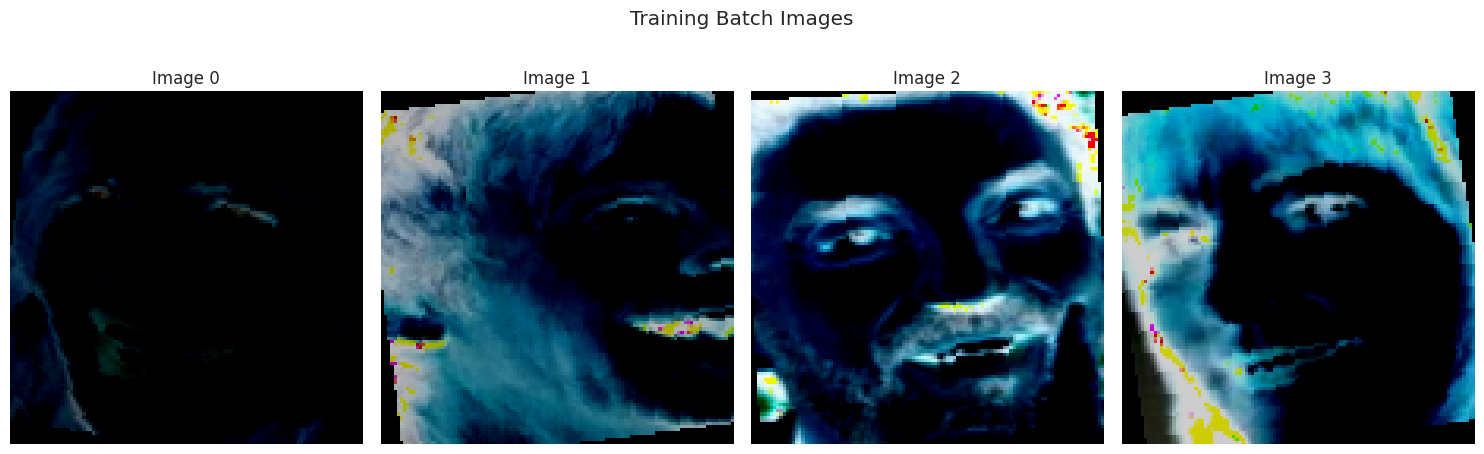


Single sample from train_dataset:
Number of items in sample: 4
  Sample item 0: shape=torch.Size([3, 112, 112]), dtype=torch.float32
    value range: [-1.000000, 0.960784]
  Sample item 1: shape=torch.Size([]), dtype=torch.float32
    value range: [37.000000, 37.000000]
  Sample item 2: shape=torch.Size([]), dtype=torch.float32
    value range: [0.000000, 0.000000]
  Sample item 3: shape=torch.Size([]), dtype=torch.float32
    value range: [59.000000, 59.000000]

Validation batch:
Number of items in batch: 4
  Item 0: shape=torch.Size([32, 3, 112, 112]), dtype=torch.float32
    batch_min=-1.000000, batch_max=1.000000
  Item 1: shape=torch.Size([32]), dtype=torch.float32
    batch_min=40.000000, batch_max=49.000000
  Item 2: shape=torch.Size([32]), dtype=torch.float32
    batch_min=0.000000, batch_max=1.000000
  Item 3: shape=torch.Size([32]), dtype=torch.float32
    batch_min=2.000000, batch_max=2.000000


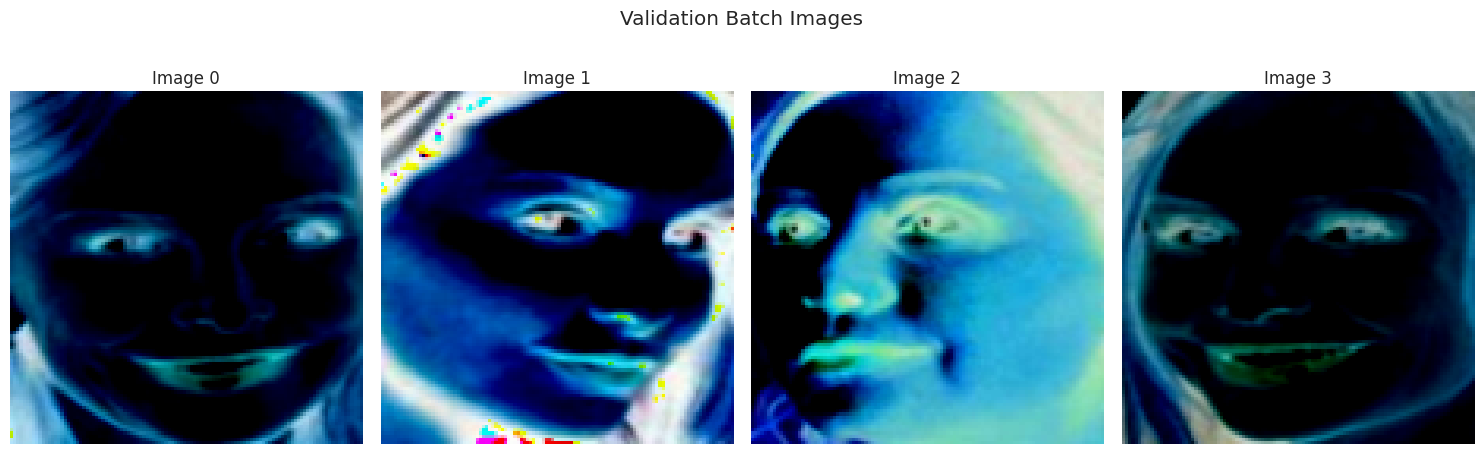


Single sample from val_dataset:
Number of items in sample: 4
  Sample item 0: shape=torch.Size([3, 112, 112]), dtype=torch.float32
    value range: [-0.992157, 0.984314]
  Sample item 1: shape=torch.Size([]), dtype=torch.float32
    value range: [47.000000, 47.000000]
  Sample item 2: shape=torch.Size([]), dtype=torch.float32
    value range: [0.000000, 0.000000]
  Sample item 3: shape=torch.Size([]), dtype=torch.float32
    value range: [2.000000, 2.000000]


In [22]:
import matplotlib.pyplot as plt
import torch

# --- DEBUG: Check the batch order ---
print("\n--- DEBUG: Checking Batch Order ---")

def plot_batch_images(batch, title, num_images=4):
    """Plot first few images from a batch"""
    if len(batch) >= 1 and batch[0].dim() >= 3:  # Check if first item is likely an image
        images = batch[0]
        fig, axes = plt.subplots(1, min(num_images, len(images)), figsize=(15, 5))
        if num_images == 1:
            axes = [axes]

        for i in range(min(num_images, len(images))):
            img = images[i]
            if img.dim() == 3:
                # Convert CHW to HWC for matplotlib
                if img.shape[0] in [1, 3]:  # Channel first
                    img = img.permute(1, 2, 0)

                # Handle single channel images
                if img.shape[2] == 1:
                    img = img.squeeze(2)

                axes[i].imshow(img, cmap='gray' if img.dim() == 2 else None)
                axes[i].set_title(f'Image {i}')
                axes[i].axis('off')

        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

# Check training batch
print("Training batch:")
for i, batch in enumerate(train_loader):
    if i >= 1:  # Only check first batch
        break

    print(f"Number of items in batch: {len(batch)}")
    for j, item in enumerate(batch):
        if torch.is_tensor(item):
            # Calculate min/max across the entire batch (batch dimension is usually first)
            batch_min = item.min().item()
            batch_max = item.max().item()
            print(f"  Item {j}: shape={item.shape}, dtype={item.dtype}")
            print(f"    batch_min={batch_min:.6f}, batch_max={batch_max:.6f}")

        else:
            print(f"  Item {j}: type={type(item)}, value={item}")

    # Plot images if available
    plot_batch_images(batch, "Training Batch Images")

    # Let's also check what the dataset returns for a single sample
    print("\nSingle sample from train_dataset:")
    sample = train_dataset[0]
    print(f"Number of items in sample: {len(sample)}")
    for k, sample_item in enumerate(sample):
        if torch.is_tensor(sample_item):
            print(f"  Sample item {k}: shape={sample_item.shape}, dtype={sample_item.dtype}")
            print(f"    value range: [{sample_item.min().item():.6f}, {sample_item.max().item():.6f}]")
        else:
            print(f"  Sample item {k}: type={type(sample_item)}, value={sample_item}")

# Check validation batch
print("\nValidation batch:")
for i, batch in enumerate(val_loader):
    if i >= 1:  # Only check first batch
        break

    print(f"Number of items in batch: {len(batch)}")
    for j, item in enumerate(batch):
        if torch.is_tensor(item):
            # Calculate min/max across the entire batch
            batch_min = item.min().item()
            batch_max = item.max().item()
            print(f"  Item {j}: shape={item.shape}, dtype={item.dtype}")
            print(f"    batch_min={batch_min:.6f}, batch_max={batch_max:.6f}")

        else:
            print(f"  Item {j}: type={type(item)}, value={item}")

    # Plot images if available
    plot_batch_images(batch, "Validation Batch Images")

    # Let's also check what the dataset returns for a single sample
    print("\nSingle sample from val_dataset:")
    sample = val_dataset[0]
    print(f"Number of items in sample: {len(sample)}")
    for k, sample_item in enumerate(sample):
        if torch.is_tensor(sample_item):
            print(f"  Sample item {k}: shape={sample_item.shape}, dtype={sample_item.dtype}")
            print(f"    value range: [{sample_item.min().item():.6f}, {sample_item.max().item():.6f}]")
        else:
            print(f"  Sample item {k}: type={type(sample_item)}, value={sample_item}")

In [23]:
# import torch


# --- 4. Verification and Sanity Check ---
print("\n--- Verifying the Training Dataset Balancing ---")
train_class_counts = train_dataset.manifest['identity_id'].value_counts()
print(f"Number of classes in training set: {len(train_class_counts)}")
print(f"Min images per class after balancing: {train_class_counts.min()}")
print(f"Max images per class after balancing: {train_class_counts.max()}")
assert train_class_counts.min() == TARGET_COUNT_PER_CLASS
assert train_class_counts.max() == TARGET_COUNT_PER_CLASS
print("✅ Verification successful: All training classes have exactly 90 images.")

print("\n--- Running a Sanity Check on the Training DataLoader ---")
start_time = time.time()
batch_images, batch_ages, batch_age_groups, batch_identities = next(iter(train_loader))
end_time = time.time()

print(f"\nSuccessfully fetched one batch in {end_time - start_time:.2f} seconds.")
print(f"  Images batch shape:       {batch_images.shape}")
print(f"  Ages batch shape:         {batch_ages.shape}")
print(f"  Age groups batch shape:   {batch_age_groups.shape}")
print(f"  Identities batch shape:   {batch_identities.shape}")
print(f"  Image value range:        [{batch_images.min():.2f}, {batch_images.max():.2f}]")


--- Verifying the Training Dataset Balancing ---
Number of classes in training set: 300
Min images per class after balancing: 90
Max images per class after balancing: 90
✅ Verification successful: All training classes have exactly 90 images.

--- Running a Sanity Check on the Training DataLoader ---

Successfully fetched one batch in 1.63 seconds.
  Images batch shape:       torch.Size([32, 3, 112, 112])
  Ages batch shape:         torch.Size([32])
  Age groups batch shape:   torch.Size([32])
  Identities batch shape:   torch.Size([32])
  Image value range:        [-1.00, 1.00]


In [24]:
# src/models/grl.py

import torch
from torch.autograd import Function

class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    """
    @staticmethod
    def forward(ctx, x, lambda_val):
        # Store lambda_val for the backward pass
        ctx.lambda_val = lambda_val
        # Forward pass is the identity function
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass reverses the gradient and scales it by lambda
        # The gradient w.r.t. lambda is None
        return (grad_output.neg() * ctx.lambda_val), None

class GradientReversalLayer(torch.nn.Module):
    def __init__(self):
        super(GradientReversalLayer, self).__init__()

    def forward(self, x, lambda_val=1.0):
        return GradientReversalFunction.apply(x, lambda_val)

In [25]:
# src/models/backbone.py

import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

def get_backbone(name: str, pretrained: bool = True):
    """
    Factory function to create a backbone model.

    Args:
        name (str): Name of the backbone (e.g., 'resnet50').
        pretrained (bool): Whether to load pretrained weights.

    Returns:
        tuple: A tuple containing:
            - nn.Module: The backbone model.
            - int: The number of output features from the backbone.

    Raises:
        ValueError: If the backbone name is not supported.
    """
    if name == 'resnet50':
        weights = ResNet50_Weights.DEFAULT if pretrained else None
        model = resnet50(weights=weights)

        # Truncate the model to remove the final avgpool and fc layers
        backbone = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )
        out_features = model.fc.in_features  # 2048 for ResNet50
        return backbone, out_features

    # You can easily add other backbones here using the same pattern.
    # For example, using the 'timm' library:
    #
    # if name == 'efficientnet_b0':
    #     import timm
    #     model = timm.create_model('efficientnet_b0', pretrained=pretrained, features_only=True)
    #     out_features = model.feature_info.channels(-1)
    #     return model, out_features

    else:
        raise ValueError(f"Backbone '{name}' not supported. Please use 'resnet50' or add a new one.")


In [26]:
# src/models/afd.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return y

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.conv(x)

class AFDModule(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(AFDModule, self).__init__()
        self.ca = ChannelAttention(in_channels, reduction_ratio)
        self.sa = SpatialAttention(kernel_size)
        # Add a final convolution to reduce the channel dimension to 1
        self.final_conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Generate channel and spatial attention logits
        channel_logits = self.ca(x)
        spatial_logits = self.sa(x)

        # Broadcast channel_logits to match spatial dimensions and combine
        combined_features = x * self.sigmoid(channel_logits) + x * self.sigmoid(spatial_logits)

        # Apply the final convolution to get a single channel attention mask
        attention_mask_logits = self.final_conv(combined_features)

        # The final mask highlights age-related features
        attention_mask = self.sigmoid(attention_mask_logits)
        return attention_mask

In [27]:
# src/models/heads.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class IdentityHead(nn.Module):
    def __init__(self, in_features, embedding_size=512):
        super(IdentityHead, self).__init__()
        self.fc = nn.Linear(in_features, embedding_size)
        self.bn = nn.BatchNorm1d(embedding_size)

    def forward(self, x):
        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        x = self.fc(x)
        x = self.bn(x)

        # L2-normalize the embeddings
        embedding = F.normalize(x, p=2, dim=1)
        return embedding

class AgeHead(nn.Module):
    def __init__(self, in_features, num_age_bins=101):
        super(AgeHead, self).__init__()
        self.fc_stack = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_age_bins)
        )

    def forward(self, x):
        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        age_logits = self.fc_stack(x)
        return age_logits

In [28]:
# src/models/aifr_model.py

import torch
import torch.nn as nn
# from .backbone import get_backbone
# from .afd import AFDModule
# from .heads import IdentityHead, AgeHead
# from .grl import GradientReversalLayer

class AIFRModel(nn.Module):
    def __init__(self, backbone_name='resnet50', embedding_size=512, num_age_bins=101, pretrained=True):
        super(AIFRModel, self).__init__()
        print(f"Initializing AIFRModel with backbone: {backbone_name}")

        # 1. Get the backbone and its output feature dimension
        self.backbone, backbone_out_features = get_backbone(backbone_name, pretrained)

        # 2. Instantiate all component modules
        self.afd = AFDModule(in_channels=backbone_out_features)
        self.identity_head = IdentityHead(in_features=backbone_out_features, embedding_size=embedding_size)

        # IMPORTANT: The AgeHead is shared between the main age prediction task and the adversarial task
        self.age_head = AgeHead(in_features=backbone_out_features, num_age_bins=num_age_bins)

        self.grl = GradientReversalLayer()

    def forward(self, image, lambda_grl=1.0):
        # --- Main Forward Pass ---
        # 1. Extract features from the backbone
        features = self.backbone(image)

        # 2. Generate the attention mask from AFD
        # This mask identifies regions/channels related to AGE
        attention_mask = self.afd(features)

        # 3. Split features into identity-focused and age-focused
        id_features = features * (1.0 - attention_mask)
        age_features = features * attention_mask

        # --- Task-Specific Paths ---
        # Path 1: Identity Recognition
        embedding = self.identity_head(id_features)

        # Path 2: Age Prediction
        age_logits = self.age_head(age_features)

        # Path 3: Adversarial Age Invariance
        reversed_id_features = self.grl(id_features, lambda_grl)
        adversarial_age_logits = self.age_head(reversed_id_features)

        # Return a dictionary for clarity in the training loop
        return {
            "embedding": embedding,
            "age_logits": age_logits,
            "adversarial_age_logits": adversarial_age_logits,
            "attention_mask": attention_mask  # Useful for visualization
        }

# --- Sanity Check ---
if __name__ == '__main__':
    print("--- Running Sanity Check for AIFRModel ---")

    # Easily switch backbones here to test
    # model = AIFRModel(backbone_name='resnet50')
    # model = AIFRModel(backbone_name='efficientnet_b0') # Would require 'timm'

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = AIFRModel(backbone_name='resnet50').to(device)
    model.eval()

    # Create a dummy input tensor
    dummy_input = torch.randn(4, 3, 112, 112).to(device) # Batch size of 4

    with torch.no_grad():
        outputs = model(dummy_input, lambda_grl=0.5)

    print("\n--- Model Initialized Successfully ---")
    print(f"Backbone: {model.backbone.__class__.__name__}")
    print("\n--- Output Shapes ---")
    for name, tensor in outputs.items():
        print(f"{name:<25}: {tensor.shape}")

    # Check output shapes
    assert outputs['embedding'].shape == (4, 512)
    assert outputs['age_logits'].shape == (4, 101)
    assert outputs['adversarial_age_logits'].shape == (4, 101)
    # For resnet50, features after layer4 on a 112x112 input are 4x4
    assert outputs['attention_mask'].shape == (4, 1, 4, 4)
    print("\n✅ Sanity check passed!")

--- Running Sanity Check for AIFRModel ---
Initializing AIFRModel with backbone: resnet50
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]



--- Model Initialized Successfully ---
Backbone: Sequential

--- Output Shapes ---
embedding                : torch.Size([4, 512])
age_logits               : torch.Size([4, 101])
adversarial_age_logits   : torch.Size([4, 101])
attention_mask           : torch.Size([4, 1, 4, 4])

✅ Sanity check passed!


In [29]:
print(model)

AIFRModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [30]:
# src/losses/age_loss.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class AgeLoss(nn.Module):
    """
    Combines DEX (Deep EXpectation) loss for continuous age regression
    and standard Cross-Entropy for age group classification.
    """
    def __init__(self, num_age_bins=101):
        super(AgeLoss, self).__init__()
        self.num_age_bins = num_age_bins
        # Create a non-trainable buffer for the age values [0, 1, 2, ..., 100]
        self.register_buffer('age_range', torch.arange(0, self.num_age_bins, dtype=torch.float32))

        # We will hardcode the group mapping for clarity
        # Bins: ['10-', '11-20', '21-30', '31-40', '41-50', '51-60', '61+']
        self.group_ranges = [
            (0, 11), (11, 21), (21, 31), (31, 41),
            (41, 51), (51, 61), (61, self.num_age_bins)
        ]
        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, age_logits, true_ages, true_age_groups):
        # --- 1. DEX Loss for Continuous Age ---
        softmax_probs = F.softmax(age_logits, dim=1)
        predicted_ages = (softmax_probs * self.age_range).sum(dim=1)
        loss_dex = self.mse_loss(predicted_ages, true_ages)

        # --- 2. CE Loss for Age Groups ---
        # Project 101 bins down to 7 groups by summing logits
        group_logits = torch.stack([
            age_logits[:, start:end].sum(dim=1) for start, end in self.group_ranges
        ], dim=1)

        true_age_groups_long = true_age_groups.long()
        loss_group = self.ce_loss(group_logits, true_age_groups_long)

        # Return a combined loss
        return loss_dex + loss_group

In [34]:
# src/losses/cosface_loss.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class CosFaceLoss(nn.Module):
    """
    Large Margin Cosine Loss (CosFace).

    Args:
        embedding_size (int): Dimension of the embedding vectors.
        num_classes (int): Number of identity classes.
        margin (float): Margin penalty.
        scale (float): Scaling factor.
    """
    def __init__(self, embedding_size, num_classes, margin=0.35, scale=64.0):
        super(CosFaceLoss, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.m = margin
        self.s = scale

        # This is the weight matrix for the final classifier
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels):
        # L2-normalize embeddings and weight matrix
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weights_normalized = F.normalize(self.weight, p=2, dim=1)

        # Calculate cosine similarity (dot product)
        cosine_sim = F.linear(embeddings, weights_normalized)

        # Create a one-hot vector for the labels
        one_hot = torch.zeros_like(cosine_sim)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        # Apply the margin penalty to the correct class
        # phi = cos(theta) - m
        output = (one_hot * (cosine_sim - self.m)) + ((1.0 - one_hot) * cosine_sim)

        # Scale the logits
        output *= self.s

        labels_long = labels.long()
        # Calculate standard cross-entropy loss
        return F.cross_entropy(output, labels_long)

In [37]:
# src/train.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import yaml
import numpy as np

# Import our custom modules
# from models.aifr_model import AIFRModel
# from losses.age_loss import AgeLoss
# from losses.cosface_loss import CosFaceLoss
# # Assuming your FaceDataset class is in data.dataloader
# from data.dataloader import FaceDataset, train_augmentations, val_augmentations, mtcnn_processor

# ANSI color codes for prettier console output
class Colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class Trainer:
    def __init__(self, config):
        self.config = config
        self.device = torch.device(config['device'])

        self._setup_dataloaders()

        self.model = AIFRModel(
            backbone_name=config['model']['backbone_name'],
            embedding_size=config['model']['embedding_size'],
            num_age_bins=config['model']['num_age_bins'],
            pretrained=config['model']['pretrained']
        ).to(self.device)

        num_train_identities = self.train_dataset.manifest['identity_id'].nunique()
        self.cosface_loss = CosFaceLoss(
            embedding_size=config['model']['embedding_size'],
            num_classes=num_train_identities
        ).to(self.device)
        self.age_loss = AgeLoss().to(self.device)

        self.optimizer = AdamW(
            list(self.model.parameters()) + list(self.cosface_loss.parameters()),
            lr=config['training']['learning_rate'],
            weight_decay=config['training']['weight_decay']
        )
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=config['training']['epochs'])
        self.scaler = torch.cuda.amp.GradScaler()

        self.best_val_mae = float('inf')
        os.makedirs(config['training']['checkpoint_dir'], exist_ok=True)

    def _setup_dataloaders(self):
        # ... (This method remains unchanged from the previous version) ...
        print("Setting up dataloaders...")
        self.train_dataset = FaceDataset(
            manifest_path=self.config['data']['train_manifest'],
            target_count_per_class=self.config['data']['target_count_per_class'],
            mtcnn_preprocessor=mtcnn_processor, # Assuming mtcnn_processor is initialized globally
            augmentations=train_augmentations,
            is_train=True
        )
        self.val_dataset = FaceDataset(
            manifest_path=self.config['data']['val_manifest'],
            target_count_per_class=None,
            mtcnn_preprocessor=mtcnn_processor,
            augmentations=val_augmentations,
            is_train=False
        )
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.config['training']['batch_size'],
            shuffle=True, num_workers=self.config['data']['num_workers'], pin_memory=True
        )
        self.val_loader = DataLoader(
            self.val_dataset, batch_size=self.config['training']['batch_size'],
            shuffle=False, num_workers=self.config['data']['num_workers'], pin_memory=True
        )
        print("Dataloaders are ready.")

    def _get_age_metrics(self, age_logits, true_ages, true_age_groups):
        # Calculate MAE
        softmax_probs = F.softmax(age_logits, dim=1)
        age_range = torch.arange(0, self.config['model']['num_age_bins'], device=self.device)
        predicted_ages = (softmax_probs * age_range).sum(dim=1)
        mae = F.l1_loss(predicted_ages, true_ages).item()

        # Calculate Group Accuracy
        group_ranges = self.age_loss.group_ranges
        group_logits = torch.stack([age_logits[:, start:end].sum(dim=1) for start, end in group_ranges], dim=1)
        predicted_groups = torch.argmax(group_logits, dim=1)
        group_acc = (predicted_groups == true_age_groups).float().mean().item()

        return mae, group_acc

    def _train_one_epoch(self, lambda_grl):
        self.model.train()
        metrics = {'loss': 0, 'loss_cosface': 0, 'loss_age': 0, 'loss_adv': 0, 'age_mae': 0, 'age_group_acc': 0}

        progress_bar = tqdm(self.train_loader, desc=f"{Colors.OKCYAN}Training{Colors.ENDC}", leave=True)
        for batch in progress_bar:
            #print("Start the loop inside train one epoch function: ")
            images, ages, age_groups, identities = [item.to(self.device) for item in batch]


            self.optimizer.zero_grad()
            #print("Calculating the loss: ")
            with torch.cuda.amp.autocast():
                outputs = self.model(images, lambda_grl=lambda_grl)
                # print("outputs: ", outputs)
                # # save the outputs in text file as text not binary:
                # with open('adversarial_age_logits.txt', 'w') as f:
                #     f.write(str(outputs['adversarial_age_logits']))

                # with open('age_logits.txt', 'w') as f:
                #     f.write(str(outputs['age_logits']))


                loss_c = self.cosface_loss(outputs['embedding'], identities)
                loss_a = self.age_loss(outputs['age_logits'], ages, age_groups)
                loss_adv = self.age_loss(outputs['adversarial_age_logits'], ages, age_groups)

                loss = (loss_c +
                        self.config['training']['lambda_age'] * loss_a +
                        self.config['training']['lambda_adv'] * loss_adv)

            #print("Updating the values: ")
            self.scaler.scale(loss).backward()
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.scaler.step(self.optimizer)
            self.scaler.update()

            # Accumulate metrics
            metrics['loss'] += loss.item()
            metrics['loss_cosface'] += loss_c.item()
            metrics['loss_age'] += loss_a.item()
            metrics['loss_adv'] += loss_adv.item()

            mae, group_acc = self._get_age_metrics(outputs['age_logits'], ages, age_groups)
            metrics['age_mae'] += mae
            metrics['age_group_acc'] += group_acc

            progress_bar.set_postfix(loss=f"{loss.item():.3f}", mae=f"{mae:.2f}")

        # Average metrics over all batches
        for k in metrics:
            metrics[k] /= len(self.train_loader)
        return metrics

    def _validate_one_epoch(self):
        self.model.eval()
        metrics = {'loss': 0, 'loss_cosface': 0, 'loss_age': 0, 'age_mae': 0, 'age_group_acc': 0}
        all_embeddings, all_labels = [], []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc=f"{Colors.OKBLUE}Validating{Colors.ENDC}", leave=True):
                images, ages, age_groups, identities = [item.to(self.device) for item in batch]

                outputs = self.model(images, lambda_grl=0.0)

                loss_a = self.age_loss(outputs['age_logits'], ages, age_groups)
                loss =  self.config['training']['lambda_age'] * loss_a

                metrics['loss'] += loss.item()
                metrics['loss_age'] += loss_a.item()

                mae, group_acc = self._get_age_metrics(outputs['age_logits'], ages, age_groups)
                metrics['age_mae'] += mae
                metrics['age_group_acc'] += group_acc

                all_embeddings.append(outputs['embedding'].cpu())
                all_labels.append(identities.cpu())

        for k in metrics:
            metrics[k] /= len(self.val_loader)

        # Calculate embedding quality
        all_embeddings = torch.cat(all_embeddings)
        all_labels = torch.cat(all_labels)
        # To avoid OOM on large val sets, we sample a subset for similarity calculation
        sample_indices = np.random.choice(len(all_embeddings), min(2048, len(all_embeddings)), replace=False)
        sample_embeddings = all_embeddings[sample_indices]
        sample_labels = all_labels[sample_indices]

        sim_matrix = F.cosine_similarity(sample_embeddings.unsqueeze(1), sample_embeddings.unsqueeze(0), dim=2)
        label_matrix = sample_labels.unsqueeze(1) == sample_labels.unsqueeze(0)
        # Remove diagonal (self-similarity)
        sim_matrix.fill_diagonal_(float('-inf'))
        label_matrix.fill_diagonal_(False)

        if label_matrix.any(): # Ensure there are positive pairs in the sample
            metrics['intra_class_sim'] = sim_matrix[label_matrix].mean().item()
        else:
            metrics['intra_class_sim'] = 0.0

        metrics['inter_class_sim'] = sim_matrix[~label_matrix].mean().item()

        return metrics

    def train(self):
        print(f"{Colors.HEADER}{Colors.BOLD}Starting AIFR Model Training{Colors.ENDC}")
        for epoch in range(self.config['training']['epochs']):
            print(f"\n{Colors.BOLD}--- Epoch {epoch+1}/{self.config['training']['epochs']} ---{Colors.ENDC}")

            current_lambda_grl = min(1.0, (epoch / self.config['training']['epochs']) * 2)
            #print("Calling train one epoch function(): ")
            train_metrics = self._train_one_epoch(lambda_grl=current_lambda_grl)
            #print("Calling validate one epoch function(): ")
            val_metrics = self._validate_one_epoch()
            self.scheduler.step()

            # --- Rich Logging Table ---
            print(f"{Colors.UNDERLINE}" + "-"*85 + f"{Colors.ENDC}")
            print(f"| {'Stage':<10} | {'Total Loss':<10} | {'CosFace Loss':<12} | {'Age Loss':<10} | {'Age MAE':<10} | {'Group Acc':<10} |")
            print("-"*85)
            print(f"| {'Train':<10} | {train_metrics['loss']:<10.4f} | {train_metrics['loss_cosface']:<12.4f} | {train_metrics['loss_age']:<10.4f} | {train_metrics['age_mae']:<10.2f} | {train_metrics['age_group_acc']*100:<9.2f}% |")
            print(f"| {'Validation':<10} | {val_metrics['loss']:<10.4f} | {val_metrics['loss_cosface']:<12.4f} | {val_metrics['loss_age']:<10.4f} | {Colors.BOLD}{val_metrics['age_mae']:<10.2f}{Colors.ENDC} | {val_metrics['age_group_acc']*100:<9.2f}% |")
            print("-"*85)
            print(f"Validation Embedding Quality: Intra-Class Sim: {Colors.OKGREEN}{val_metrics['intra_class_sim']:.3f}{Colors.ENDC} | Inter-Class Sim: {Colors.FAIL}{val_metrics['inter_class_sim']:.3f}{Colors.ENDC}")

            val_mae = val_metrics['age_mae']
            if val_mae < self.best_val_mae:
                self.best_val_mae = val_mae
                save_path = os.path.join(self.config['training']['checkpoint_dir'], "best_model.pth")
                torch.save(self.model.state_dict(), save_path)
                print(f"{Colors.OKGREEN}🎉 New best model saved with MAE: {val_mae:.2f} at {save_path}{Colors.ENDC}")



In [ ]:
if __name__ == '__main__':
    CONFIG = {
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'data': { 'train_manifest': '/kaggle/working/manifests/train_manifest.csv', 'val_manifest': '/kaggle/working/manifests/val_manifest.csv', 'target_count_per_class': 90, 'num_workers': 0 },
        'model': { 'backbone_name': 'resnet50', 'embedding_size': 512, 'num_age_bins': 101, 'pretrained': True },
        'training': { 'epochs': 25, 'batch_size': 64, 'learning_rate': 1e-4, 'weight_decay': 5e-4, 'lambda_age': 0.5, 'lambda_adv': 0.7, 'checkpoint_dir': 'checkpoints/' }
    }

    trainer = Trainer(CONFIG)
    trainer.train()

Setting up dataloaders...
Filtering out corrupted or missing image files...
Filtering complete. Removed 0 invalid files.
Balancing all classes to have exactly 90 images...
Resampling complete. Dataset size changed from 23539 to 27000.
Filtering out corrupted or missing image files...
Filtering complete. Removed 0 invalid files.
Dataloaders are ready.
Initializing AIFRModel with backbone: resnet50


/tmp/ipykernel_36/577245910.py:60: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Starting AIFR Model Training

--- Epoch 1/25 ---


Training:   0%|          | 0/422 [00:00<?, ?it/s]/tmp/ipykernel_36/577245910.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validating: 100%|██████████| 123/123 [06:49<00:00,  3.33s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 153.4476   | 28.8928      | 103.2114   | 7.95       | 31.73    % |
| Validation | 44.5699    | 0.0000       | 89.1397    | 7.18       | 17.91    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.292 | Inter-Class Sim: -inf
🎉 New best model saved with MAE: 7.18 at checkpoints/best_model.pth

--- Epoch 2/25 ---


Validating: 100%|██████████| 123/123 [06:48<00:00,  3.32s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 101.4546   | 25.1717      | 63.3399    | 5.99       | 44.49    % |
| Validation | 39.8481    | 0.0000       | 79.6962    | 6.69       | 14.63    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.287 | Inter-Class Sim: -inf
🎉 New best model saved with MAE: 6.69 at checkpoints/best_model.pth

--- Epoch 3/25 ---


Validating: 100%|██████████| 123/123 [06:33<00:00,  3.20s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 81.6886    | 22.3631      | 48.7783    | 5.13       | 50.83    % |
| Validation | 41.3809    | 0.0000       | 82.7619    | 6.71       | 16.35    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.203 | Inter-Class Sim: -inf

--- Epoch 4/25 ---


Validating: 100%|██████████| 123/123 [06:48<00:00,  3.32s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 150.6500   | 22.2405      | 51.1754    | 5.37       | 43.79    % |
| Validation | 52.9208    | 0.0000       | 105.8416   | 8.60       | 20.73    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.267 | Inter-Class Sim: -inf

--- Epoch 5/25 ---


Validating: 100%|██████████| 123/123 [06:56<00:00,  3.39s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 171.5049   | 21.3103      | 45.6882    | 5.04       | 48.36    % |
| Validation | 72.9879    | 0.0000       | 145.9758   | 10.33      | 9.03     % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.261 | Inter-Class Sim: -inf

--- Epoch 6/25 ---


Validating: 100%|██████████| 123/123 [06:52<00:00,  3.35s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 150.3263   | 18.9420      | 37.9617    | 4.53       | 56.23    % |
| Validation | 69.2192    | 0.0000       | 138.4384   | 10.01      | 15.46    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.223 | Inter-Class Sim: -inf

--- Epoch 7/25 ---


Validating: 100%|██████████| 123/123 [07:05<00:00,  3.46s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 142.9343   | 15.9989      | 31.3328    | 4.08       | 61.46    % |
| Validation | 69.6971    | 0.0000       | 139.3941   | 10.06      | 18.46    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.226 | Inter-Class Sim: -inf

--- Epoch 8/25 ---


Validating: 100%|██████████| 123/123 [07:01<00:00,  3.43s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 141.7869   | 15.8802      | 27.2419    | 3.81       | 62.36    % |
| Validation | 71.3010    | 0.0000       | 142.6021   | 10.18      | 22.35    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.220 | Inter-Class Sim: -inf

--- Epoch 9/25 ---


Validating: 100%|██████████| 123/123 [06:39<00:00,  3.25s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 135.5107   | 13.3039      | 23.4289    | 3.51       | 65.61    % |
| Validation | 70.7898    | 0.0000       | 141.5795   | 10.15      | 22.03    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.216 | Inter-Class Sim: -inf

--- Epoch 10/25 ---


Validating: 100%|██████████| 123/123 [06:46<00:00,  3.30s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 131.1327   | 11.9742      | 20.9793    | 3.30       | 67.35    % |
| Validation | 70.7034    | 0.0000       | 141.4068   | 10.14      | 11.61    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.191 | Inter-Class Sim: -inf

--- Epoch 11/25 ---


Validating: 100%|██████████| 123/123 [07:09<00:00,  3.49s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 132.2036   | 11.6005      | 18.9082    | 3.15       | 67.72    % |
| Validation | 71.0376    | 0.0000       | 142.0752   | 10.17      | 26.21    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.237 | Inter-Class Sim: -inf

--- Epoch 12/25 ---


Validating: 100%|██████████| 123/123 [06:35<00:00,  3.21s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 127.8576   | 10.0579      | 17.2572    | 3.02       | 69.13    % |
| Validation | 71.4793    | 0.0000       | 142.9585   | 10.15      | 26.14    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.170 | Inter-Class Sim: -inf

--- Epoch 13/25 ---


Validating: 100%|██████████| 123/123 [06:43<00:00,  3.28s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 127.4187   | 9.5629       | 16.2086    | 2.92       | 66.55    % |
| Validation | 73.4413    | 0.0000       | 146.8825   | 10.15      | 26.24    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.183 | Inter-Class Sim: -inf

--- Epoch 14/25 ---


Validating: 100%|██████████| 123/123 [07:03<00:00,  3.44s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 124.1403   | 8.3876       | 14.1243    | 2.72       | 71.76    % |
| Validation | 72.0010    | 0.0000       | 144.0020   | 10.15      | 26.24    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.193 | Inter-Class Sim: -inf

--- Epoch 15/25 ---


Validating: 100%|██████████| 123/123 [06:51<00:00,  3.34s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 123.3494   | 7.9377       | 13.1812    | 2.61       | 72.79    % |
| Validation | 71.5394    | 0.0000       | 143.0788   | 10.15      | 7.16     % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.169 | Inter-Class Sim: -inf

--- Epoch 16/25 ---


Validating: 100%|██████████| 123/123 [07:07<00:00,  3.48s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 121.1643   | 7.0444       | 11.2678    | 2.41       | 75.15    % |
| Validation | 71.1016    | 0.0000       | 142.2032   | 10.15      | 17.72    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.205 | Inter-Class Sim: -inf

--- Epoch 17/25 ---


Validating: 100%|██████████| 123/123 [06:55<00:00,  3.38s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 120.3267   | 7.1249       | 10.3629    | 2.31       | 75.12    % |
| Validation | 71.8787    | 0.0000       | 143.7575   | 10.13      | 26.14    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.168 | Inter-Class Sim: -inf

--- Epoch 18/25 ---


Validating: 100%|██████████| 123/123 [07:17<00:00,  3.56s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 118.8292   | 6.0983       | 9.4742     | 2.19       | 77.40    % |
| Validation | 72.7346    | 0.0000       | 145.4692   | 10.15      | 6.05     % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.184 | Inter-Class Sim: -inf

--- Epoch 19/25 ---


Validating: 100%|██████████| 123/123 [07:12<00:00,  3.52s/it]


-------------------------------------------------------------------------------------
| Stage      | Total Loss | CosFace Loss | Age Loss   | Age MAE    | Group Acc  |
-------------------------------------------------------------------------------------
| Train      | 125.6617   | 8.5896       | 12.9722    | 2.61       | 73.38    % |
| Validation | 71.1005    | 0.0000       | 142.2011   | 10.17      | 29.19    % |
-------------------------------------------------------------------------------------
Validation Embedding Quality: Intra-Class Sim: 0.165 | Inter-Class Sim: -inf

--- Epoch 20/25 ---


Training:  52%|█████▏    | 221/422 [12:40<12:07,  3.62s/it, loss=127.772, mae=2.11]